In [1]:
import gym
from gym import envs
env = gym.make('Blackjack-v0')

In [2]:
dir(env)
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

# Задание 1
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [3]:
import numpy as np

debug =  False
results = []
num_iter = 500000

for i in range(num_iter):
    cur, dealer, space = env.reset()
    
    if debug: print("start", cur, dealer, space)
    
    is_finished = False
    while cur <= 18:
        state, score, is_finished, some =  env.step(1)
        cur = state[0]
        if debug: print("more", cur, score, is_finished, some)
    
    if is_finished:
        results.append(score)
    else:
        state, score, is_finished, some = env.step(0)
        if debug: print("stop", state, score, is_finished, some)  
        assert is_finished == True
        results.append(score)

print(f'средний выигрыш по стратегии {np.mean(np.array(results))}') 

средний выигрыш по стратегии -0.200684


Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [4]:
num_states = 32*11*2
num_actions = 2

def index_by_state(state):
    return state[0], state[1], int(state[2])


def egreedy_policy(q_values, state, epsilon=0.1):  
    if np.random.random() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values[index_by_state(state)])

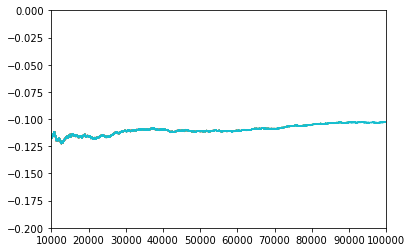

last_avg_reward -0.103


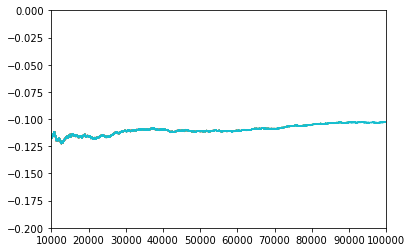

In [5]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def conduct_experiment(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((32, 11, 2, num_actions), float)
    states_counter = np.zeros((32, 11, 2, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        if debug: print("state", state)

        done = False

        while not done:
            action = egreedy_policy(q_values, state, epsilon)
            if debug: print("action", action)

            next_state, reward, done, some = env.step(action)

            if debug: print("next_state", next_state, reward, done, some, q_values[index_by_state(next_state)])
            if debug: print("old value", q_values[index_by_state(state)], reward, np.max(q_values[index_by_state(state)]))            

            q_values[index_by_state(state)][action] += learning_rate * \
            (reward + np.max(q_values[index_by_state(next_state)] if not done else 0)\
            - q_values[index_by_state(state)][action])
            
            states_counter[index_by_state(state)][action] += 1

            if debug: print("new value", q_values[index_by_state(state)])

            state = next_state
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {round(avg_rewards[-1],3)}')
    return avg_rewards, states_counter, q_values
    
avg_rewards, states_counter, q_values = conduct_experiment(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, debug = False, plot = True)


In [6]:
# пройдемся по посещенным состояниям и выведем Q
for i in range(32):
    for j in range(11):
        for k in range(2):
            if np.max(states_counter[i, j, k]) > 0:
                print(i, j, bool(k), " : ", np.round(q_values[i, j, k][:],2), states_counter[i,j,k], np.argmax(q_values[i, j, k]))

4 1 False  :  [-0.3  -0.25] [ 7. 30.] 1
4 2 False  :  [-0.19 -0.15] [12. 48.] 1
4 3 False  :  [-0.13 -0.06] [ 9. 44.] 1
4 4 False  :  [-0.19 -0.07] [ 6. 39.] 1
4 5 False  :  [-0.09 -0.03] [ 8. 37.] 1
4 6 False  :  [-0.14 -0.04] [ 3. 35.] 1
4 7 False  :  [-0.19 -0.07] [ 4. 38.] 1
4 8 False  :  [-0.19 -0.17] [ 4. 26.] 1
4 9 False  :  [-0.31 -0.25] [10. 49.] 1
4 10 False  :  [-0.34 -0.3 ] [ 24. 181.] 1
5 1 False  :  [-0.46 -0.42] [12. 61.] 1
5 2 False  :  [-0.19 -0.16] [20. 72.] 1
5 3 False  :  [-0.16 -0.11] [37. 59.] 1
5 4 False  :  [-0.11 -0.1 ] [11. 70.] 1
5 5 False  :  [-0.15 -0.08] [39. 60.] 1
5 6 False  :  [-0.14  0.01] [19. 70.] 1
5 7 False  :  [-0.17 -0.11] [16. 73.] 1
5 8 False  :  [-0.22 -0.22] [ 7. 61.] 1
5 9 False  :  [-0.24 -0.24] [17. 62.] 0
5 10 False  :  [-0.52 -0.36] [ 38. 313.] 1
6 1 False  :  [-0.58 -0.46] [ 17. 127.] 1
6 2 False  :  [-0.07 -0.09] [ 33. 100.] 0
6 3 False  :  [-0.3  -0.15] [ 11. 135.] 1
6 4 False  :  [-0.16 -0.12] [ 37. 119.] 1
6 5 False  :  [-0.19 -0.03

Поподбираем гиперпараметры, но в целом на миллионе итераций максимум вышел на learnnig_rate 0.01 и таким же epsilon, мельче я не дробил. Оставлю тут код для более широкого range

начинаем эксперимент, lr = 0.01 epsilon = 0.02 num_iter = 100000
last_avg_reward -0.074
начинаем эксперимент, lr = 0.01 epsilon = 0.04 num_iter = 100000
last_avg_reward -0.09
начинаем эксперимент, lr = 0.01 epsilon = 0.06 num_iter = 100000
last_avg_reward -0.094
начинаем эксперимент, lr = 0.01 epsilon = 0.08 num_iter = 100000
last_avg_reward -0.096
начинаем эксперимент, lr = 0.01 epsilon = 0.1 num_iter = 100000
last_avg_reward -0.102
начинаем эксперимент, lr = 0.04 epsilon = 0.02 num_iter = 100000
last_avg_reward -0.075
начинаем эксперимент, lr = 0.04 epsilon = 0.04 num_iter = 100000
last_avg_reward -0.086
начинаем эксперимент, lr = 0.04 epsilon = 0.06 num_iter = 100000
last_avg_reward -0.093
начинаем эксперимент, lr = 0.04 epsilon = 0.08 num_iter = 100000
last_avg_reward -0.097
начинаем эксперимент, lr = 0.04 epsilon = 0.1 num_iter = 100000
last_avg_reward -0.11
начинаем эксперимент, lr = 0.07 epsilon = 0.02 num_iter = 100000
last_avg_reward -0.081
начинаем эксперимент, lr = 0.07 epsi

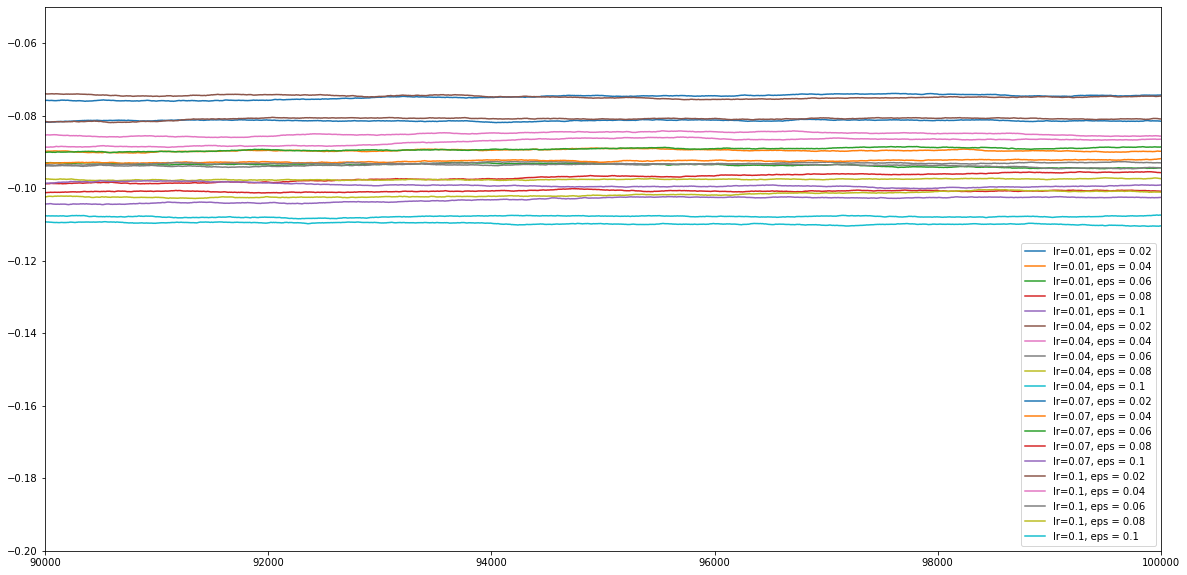

In [7]:
plt.figure(figsize=(20,10))

for learning_rate in np.linspace(0.01, 0.1, 4):
    for epsilon in np.linspace(0.02, 0.1, 5):
        avg_rewards, states_counter, q_values = conduct_experiment(learning_rate, epsilon)
        plt.plot(avg_rewards, label = f'lr={learning_rate}, eps = {epsilon}')
        
plt.xlim(90000, 100000)
plt.ylim(-0.2,-0.05)
plt.legend(loc='lower right')
plt.show()

# Задание 2

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. 

Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. 

Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


Просто добавим в класс метод step_new

In [8]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    # добавим новый метод, так проще всего реализовать
    def step_new(self, action):
        if self.action_space.contains(action):
            return self.step(action)
        else:
            state, reward, done, empty = self.step(1)
            if done:
                return state, reward * 2, done, empty
            else:
                state, reward, done, empty = self.step(0)
                assert done==True
                return state, reward * 2, done, empty

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()


In [9]:
env = BlackjackEnv()
env.reset()

(12, 3, False)

In [10]:
# переопределим число действий
num_actions = 3

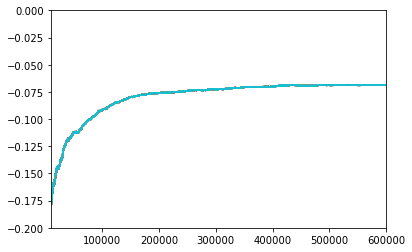

last_avg_reward -0.069


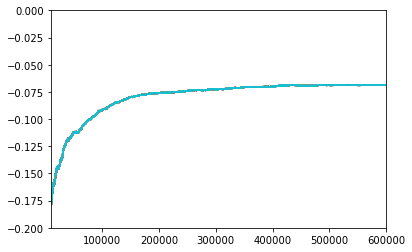

In [11]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((32, 11, 2, num_actions), float)
    states_counter = np.zeros((32, 11, 2, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        if debug: print("state", state)

        done = False

        while not done:
            action = egreedy_policy(q_values, state, epsilon)
            if debug: print("action", action)

            next_state, reward, done, some = env.step_new(action)

            if debug: print("next_state", next_state, reward, done, some, q_values[index_by_state(next_state)])
            if debug: print("old value", q_values[index_by_state(state)], reward, np.max(q_values[index_by_state(state)]))            

            q_values[index_by_state(state)][action] += learning_rate * \
            (reward + np.max(q_values[index_by_state(next_state)] if not done else 0)\
            - q_values[index_by_state(state)][action])
            
            states_counter[index_by_state(state)][action] += 1

            if debug: print("new value", q_values[index_by_state(state)])

            state = next_state
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {round(avg_rewards[-1],3)}')
    return avg_rewards, states_counter, q_values
   
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.03, epsilon = 0.01, num_iterations = 600000, debug = False, plot = True)

In [12]:
# пройдемся по посещенным состояниям и выведем Q
for i in range(32):
    for j in range(11):
        for k in range(2):
            if np.max(states_counter[i, j, k]) > 0:
                print(i, j, bool(k), " : ", np.round(q_values[i, j, k][:],2), states_counter[i,j,k], np.argmax(q_values[i, j, k]))

4 1 False  :  [-0.49 -0.45 -0.52] [ 36. 241.  15.] 1
4 2 False  :  [-0.17 -0.17 -0.18] [ 26. 224.   5.] 0
4 3 False  :  [-0.19 -0.1  -0.17] [  9. 245.   3.] 1
4 4 False  :  [-0.14 -0.08 -0.18] [ 11. 268.  13.] 1
4 5 False  :  [-0.11 -0.06 -0.11] [  4. 284.  10.] 1
4 6 False  :  [-0.14 -0.08 -0.17] [  5. 243.   3.] 1
4 7 False  :  [-0.19 -0.12 -0.18] [  9. 277.   5.] 1
4 8 False  :  [-0.26 -0.17 -0.33] [ 25. 254.   8.] 1
4 9 False  :  [-0.32 -0.24 -0.34] [ 22. 245.  10.] 1
4 10 False  :  [-0.45 -0.36 -0.45] [  28. 1103.   13.] 1
5 1 False  :  [-0.55 -0.46 -0.6 ] [ 37. 503.  14.] 1
5 2 False  :  [-0.19 -0.18 -0.26] [  9. 537.  13.] 1
5 3 False  :  [-0.21 -0.13 -0.23] [ 14. 528.   6.] 1
5 4 False  :  [-0.19 -0.14 -0.15] [ 22. 473.  13.] 1
5 5 False  :  [-0.13 -0.1  -0.12] [ 11. 481.  38.] 1
5 6 False  :  [-0.18 -0.05 -0.23] [ 32. 551.  14.] 1
5 7 False  :  [-0.18 -0.06 -0.33] [ 15. 497.   6.] 1
5 8 False  :  [-0.27 -0.24 -0.36] [ 15. 538.   9.] 1
5 9 False  :  [-0.36 -0.26 -0.38] [ 20. 50


Видно что удваивать иногда имеет смысл только если при сдаче выпаало 10 или 11 очков

Потюним гиперпараметры, 0.02 0.005 выглядит наиболее многообещающим

начинаем эксперимент, lr = 0.01 epsilon = 0.005 num_iter = 500000
last_avg_reward -0.069
начинаем эксперимент, lr = 0.01 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.074
начинаем эксперимент, lr = 0.02 epsilon = 0.005 num_iter = 500000
last_avg_reward -0.066
начинаем эксперимент, lr = 0.02 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.067
начинаем эксперимент, lr = 0.03 epsilon = 0.005 num_iter = 500000
last_avg_reward -0.067
начинаем эксперимент, lr = 0.03 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.068
начинаем эксперимент, lr = 0.04 epsilon = 0.005 num_iter = 500000
last_avg_reward -0.066
начинаем эксперимент, lr = 0.04 epsilon = 0.01 num_iter = 500000
last_avg_reward -0.066


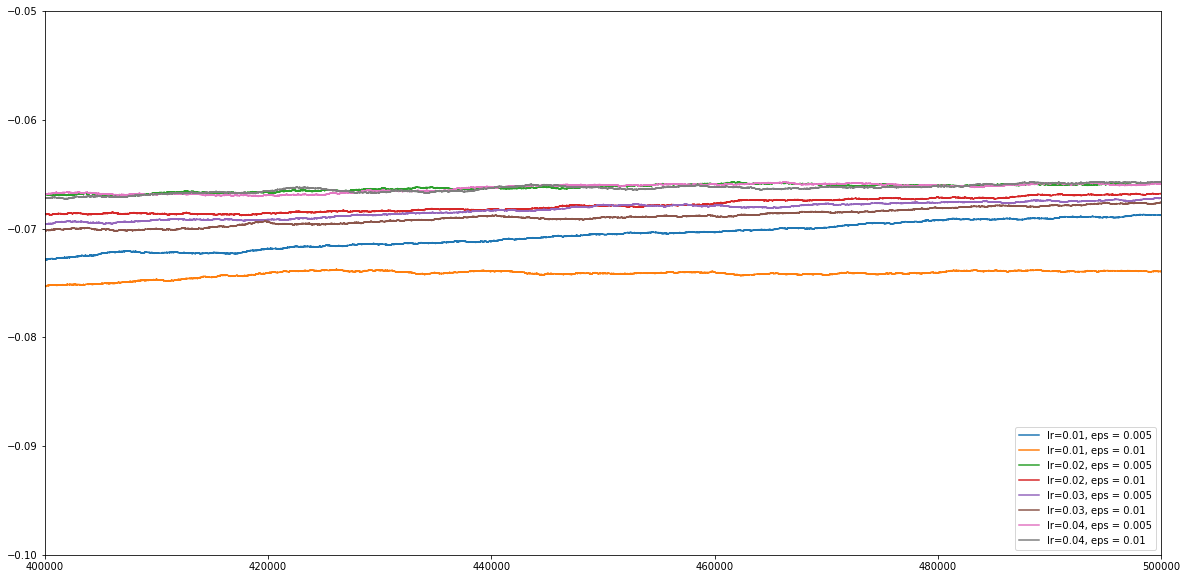

In [13]:
plt.figure(figsize=(20,10))

for learning_rate in np.linspace(0.01, 0.04, 4):
    for epsilon in np.linspace(0.005, 0.01, 2):
        #epsilon = 0.01
        avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate, epsilon, 500000)
        plt.plot(avg_rewards, label = f'lr={learning_rate}, eps = {epsilon}')
        
plt.xlim(400000, 500000)
plt.ylim(-0.1,-0.05)
plt.legend(loc='lower right')
plt.show()

# Задание 3

Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [14]:
import gym
from gym import spaces
from gym.utils import seeding
import random
import numpy as np
from collections import Counter


def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10

deck_new = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv_real(gym.Env):
    def __init__(self, debug = False, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.natural = natural
        # Start the first game
        # это индекс карты которая будет сдана следующей
        self.current_indedx = 0
        # поместим колоду внутрь класса
        self.deck = deck_new.copy()
        self.debug = debug
        self.init_deck()
        self.reset()
        if self.debug: print("finish init")

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        return self._get_obs(), reward, done, self.current_index

    # добавим новый метод т.к. все сформулировано в его методах
    def step_new(self, action):
        if self.action_space.contains(action):
            return self.step(action)
        else:
            state, reward, done, empty = self.step(1)
            if not done:
                state, reward, done, empty = self.step(0)

            return state, reward * 2, done, self.current_index

    def _get_obs(self):
        # out_cards -то что вышло до начала розыгрыша
        out_cards = Counter(self.deck[0:self.current_index - len(self.player) - len(self.dealer)])
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), (self.player, self.dealer, out_cards))

    def reset(self):
        self.check_deck()
        self.dealer = self.draw_hand() 
        self.player = self.draw_hand()
        return self._get_obs()
    
    def init_deck(self):
        self.current_index = 0
        self.deck = deck_new.copy()
        random.shuffle(self.deck)
        if self.debug: print(self.deck)


    def check_deck(self):
    # если карт мало и мы закончили - достаем колоду
        if 52 - self.current_index < 15:
            self.init_deck()    

    def draw_card(self):
        card = self.deck[self.current_index]
        self.current_index += 1
        return card

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]


Сначала просто помоделируем игры, чтобы убедиться, что все запрогано верно

In [15]:
debug =  True
env = BlackjackEnv_real(debug)
env.init_deck()


results = []
num_iter = 10

for i in range(num_iter):
    cur, dealer, space, played_cards = env.reset()
    
    if debug: print("start", cur, dealer, space)
    
    is_finished = False
    while cur <= 18:
        state, reward, is_finished, index =  env.step(1)
        cur = state[0]
        if debug: print("more", cur, reward, is_finished, index)
    
    if is_finished:
        if debug: print("stop", state, reward, is_finished, index)  
        results.append(reward)
    else:
        state, reward, is_finished, index = env.step(0)
        if debug: print("stop", state, reward, is_finished, index)  
        assert is_finished == True
        results.append(reward)
print(np.mean(np.array(results)))  

[5, 8, 4, 7, 3, 5, 8, 6, 9, 10, 7, 6, 10, 10, 1, 2, 5, 10, 10, 2, 4, 1, 4, 5, 10, 4, 10, 6, 2, 10, 7, 1, 10, 3, 10, 6, 10, 3, 9, 7, 10, 10, 10, 1, 3, 9, 10, 10, 2, 9, 8, 8]
finish init
[10, 1, 2, 10, 2, 10, 10, 4, 10, 2, 10, 5, 3, 9, 10, 5, 6, 10, 4, 10, 10, 6, 5, 10, 4, 10, 1, 6, 10, 7, 5, 7, 4, 10, 8, 1, 10, 8, 7, 3, 6, 8, 2, 9, 3, 9, 9, 3, 8, 10, 7, 1]
start 12 10 False
more 14 0.0 False 5
more 24 -1.0 True 6
stop (24, 10, False, ([2, 10, 2, 10], [10, 1], Counter())) -1.0 True 6
start 12 10 False
more 22 -1.0 True 11
stop (22, 10, False, ([10, 2, 10], [10, 4], Counter({10: 3, 2: 2, 1: 1}))) -1.0 True 11
start 19 5 False
stop (19, 5, False, ([9, 10], [5, 3, 5, 6], Counter({10: 6, 2: 3, 1: 1, 4: 1}))) 0.0 True 17
start 20 10 False
stop (20, 10, False, ([10, 10], [10, 4, 6], Counter({10: 7, 2: 3, 5: 2, 1: 1, 4: 1, 3: 1, 9: 1, 6: 1}))) 0.0 True 22
start 14 5 False
more 15 0.0 False 27
more 21 0.0 False 28
stop (21, 5, False, ([4, 10, 1, 6], [5, 10, 10], Counter({10: 10, 2: 3, 4: 2, 5: 2

Тест на предыдущей задаче

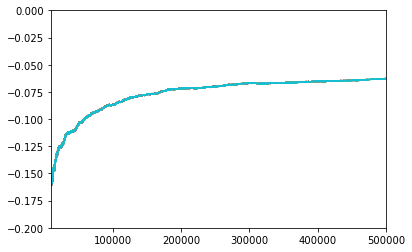

last_avg_reward -0.063


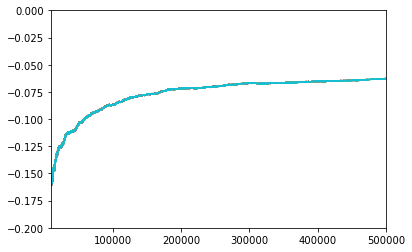

In [16]:
debug = False
env = BlackjackEnv_real(debug)
env.init_deck()
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.02, epsilon = 0.001, num_iterations = 500000, debug = debug, plot = True)

+- сошлось

Попробуем сделать как "замечательной книге Стэнфорда Уонга", также сгруппируем по числу карт до начала игры:
[15, 23] [24, 34] [35, 52] по картам [, -7.5] [-7.5, -4.5] [-4.5, -1.5] [-1.5, 1.5] [1.5, 4.5] [4.5, 7.5] [7.5 , +]

In [17]:
def cards_score(card):
    if card in [2, 7]: 
        return 0.5
    elif card in [3, 4, 6]: 
        return 1.
    elif card == 5:
        return 1.5
    elif card == 8:
        return 0.
    elif card == 9:
        return -0.5
    elif card in [10, 1]:
        return -1

def map_card_state(sum_cards):
    mult = np.sign(sum_cards)
    state = int((abs(sum_cards) + 1)/3) 
    state = 3 if state > 3 else state
    return int(state * mult + 3)

   
def get_initial_pos_state(size):
    if size > 23:
        return 0
    elif size > 34:
        return 1
    else:
        return 2
    
# получаем состояние по числу оставшихся карт в колоде и 
def get_composite_state(cards):
    score = 0
    size = 0
    for k in cards.keys():
        score += cards_score(k) * cards[k]
        size += cards[k]
    card_state = map_card_state(score) # 0 to 7
    size_state = get_initial_pos_state(size) # 0 to 3
    return size_state, card_state

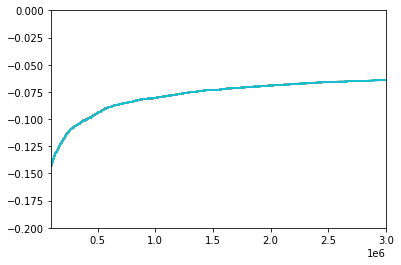

last_avg_reward -0.06435166666666313


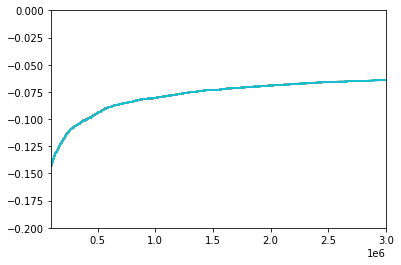

In [18]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

num_states = 3*7*32*11*2
num_actions = 3

def get_code_by_state(state):
    state_dims = [3, 7, 32 ,11, 2]
    size_state, card_state = get_composite_state(state[3][2])
    states = [size_state, card_state, state[0], state[1], (1 if state[2] else 0)]
    state_code = states[0]
    for i in range(1, len(states)):
        state_code = state_code * state_dims[i] + states[i]
    return state_code 

def get_state_by_code(code):
    state_dims = [3, 7, 32 ,11, 2]
    result = []
    for i in range(len(state_dims)-1, -1, -1):
        result.append(code%state_dims[i])
        code = int(code/state_dims[i])
        result.reverse()
    return tuple(result)


def egreedy_policy(q_values, state, epsilon=0.1):  
    if np.random.random() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values[state])


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, index = env.step_new(action)

            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%100000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(100000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values


debug = False
env = BlackjackEnv_real(debug)
env.init_deck()
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.03, epsilon = 0.01, num_iterations = 3000000, debug = debug, plot = True)



In [19]:
for i in range(num_states):
    if np.max(states_counter[i][:]) > 0:
        print(get_state_by_code(i), ":", np.round(q_values[i][:],2), states_counter[i], np.argmax(q_values[i]))

(0, 4, 0, 2, 0) : [-0.03  0.    0.  ] [1. 5. 0.] 1
(0, 4, 0, 3, 0) : [-0.03 -0.02 -0.06] [1. 7. 1.] 1
(0, 4, 0, 4, 0) : [-0.03 -0.01 -0.06] [1. 3. 3.] 1
(0, 4, 0, 5, 0) : [-0.03 -0.02 -0.06] [1. 9. 5.] 1
(0, 4, 0, 6, 0) : [-0.    0.   -0.06] [4. 2. 1.] 1
(0, 4, 0, 7, 0) : [-0.03 -0.01 -0.06] [1. 7. 1.] 1
(0, 4, 0, 8, 0) : [0.03 0.   0.  ] [3. 0. 0.] 0
(0, 4, 0, 9, 0) : [-0.03  0.    0.  ] [1. 0. 0.] 1
(0, 4, 0, 10, 0) : [-0.03 -0.   -0.06] [1. 4. 1.] 1
(0, 5, 0, 1, 0) : [-0.03 -0.02 -0.06] [1. 3. 1.] 1
(0, 5, 0, 2, 0) : [-0.03 -0.02 -0.06] [1. 9. 1.] 1
(0, 5, 0, 3, 0) : [-0.03 -0.03 -0.06] [ 1. 20.  1.] 1
(0, 5, 0, 4, 0) : [-0.06 -0.04 -0.06] [ 2. 32.  1.] 1
(0, 5, 0, 5, 0) : [-0.03 -0.02 -0.07] [5. 4. 7.] 1
(0, 5, 0, 6, 0) : [-0.03 -0.02 -0.12] [ 1. 20.  2.] 1
(0, 5, 0, 7, 0) : [-0.03  0.01 -0.06] [ 1. 21.  1.] 1
(0, 5, 0, 8, 0) : [-0.03 -0.   -0.06] [ 5. 12.  3.] 1
(0, 5, 0, 9, 0) : [-0.03 -0.02 -0.06] [ 1. 18.  1.] 1
(0, 5, 0, 10, 0) : [-0.06 -0.06 -0.06] [ 2. 48.  1.] 1
(0, 6, 0, 1

(0, 11, 0, 3, 1) : [-0.    0.23  0.  ] [  4. 616.   2.] 1
(0, 11, 0, 4, 1) : [-0.06  0.07 -0.05] [  8. 549.  52.] 1
(0, 11, 0, 5, 1) : [-0.09  0.11  0.01] [  3. 640.  21.] 1
(0, 11, 0, 6, 1) : [-0.    0.17 -0.06] [  6. 575.   1.] 1
(0, 11, 0, 7, 1) : [-0.03  0.19 -0.12] [  3. 584.   2.] 1
(0, 11, 0, 8, 1) : [ 0.    0.15 -0.11] [  2. 476.   4.] 1
(0, 11, 0, 9, 1) : [-0.09  0.13 -0.08] [  7. 357.  17.] 1
(0, 11, 0, 10, 1) : [-0.16  0.04 -0.11] [  10. 1365.  110.] 1
(0, 12, 0, 1, 1) : [-0.54 -0.42 -0.56] [ 28. 485.  21.] 1
(0, 12, 1, 1, 1) : [-0.03 -0.   -0.06] [1. 2. 1.] 1
(0, 12, 0, 2, 1) : [-0.32 -0.24 -0.35] [ 25. 766.  32.] 1
(0, 12, 1, 2, 1) : [-0.03  0.05  0.  ] [ 1. 10.  0.] 1
(0, 12, 0, 3, 1) : [-0.34 -0.19 -0.41] [ 44. 879.  19.] 1
(0, 12, 1, 3, 1) : [-0.    0.06  0.  ] [ 2. 10.  0.] 1
(0, 12, 0, 4, 1) : [-0.49 -0.26 -0.49] [137. 759.  44.] 1
(0, 12, 1, 4, 1) : [-0.03 -0.01 -0.06] [ 1. 12.  1.] 1
(0, 12, 0, 5, 1) : [-0.4  -0.18 -0.35] [  56. 1006.   46.] 1
(0, 12, 1, 5, 1) : [-0

(0, 14, 1, 3, 2) : [-0.09  0.09 -0.03] [  3. 203.  52.] 1
(0, 14, 0, 4, 2) : [-0.14 -0.55 -0.7 ] [ 890. 1523.   92.] 0
(0, 14, 1, 4, 2) : [-0.06 -0.01 -0.07] [  4. 155. 153.] 1
(0, 14, 0, 5, 2) : [-0.45 -0.43 -0.6 ] [2378.  492.   41.] 1
(0, 14, 1, 5, 2) : [-0.03  0.14 -0.05] [  3. 286.  41.] 1
(0, 14, 0, 6, 2) : [-0.38 -0.51 -0.53] [2128.  453.   38.] 0
(0, 14, 1, 6, 2) : [-0.09  0.12 -0.05] [  3. 281.   3.] 1
(0, 14, 0, 7, 2) : [-0.58 -0.3  -0.52] [ 179. 2298.   61.] 1
(0, 14, 1, 7, 2) : [-0.03  0.08 -0.01] [  1. 268.  15.] 1
(0, 14, 0, 8, 2) : [-0.63 -0.33 -0.83] [  96. 2346.   30.] 1
(0, 14, 1, 8, 2) : [-0.03  0.04 -0.06] [  1. 262.   1.] 1
(0, 14, 0, 9, 2) : [-0.43 -0.32 -0.65] [  78. 2075.   42.] 1
(0, 14, 1, 9, 2) : [-0.09  0.08 -0.06] [  5. 221.   3.] 1
(0, 14, 0, 10, 2) : [-0.63 -0.41 -0.67] [  71. 8040.   66.] 1
(0, 14, 1, 10, 2) : [-0.1  0.  -0.2] [  8. 772.  47.] 1
(0, 15, 0, 1, 2) : [-0.72 -0.48 -0.81] [  62. 2098.   71.] 1
(0, 15, 1, 1, 2) : [-0.28 -0.23 -0.31] [ 13. 152.

(0, 17, 1, 4, 3) : [-0.08 -0.01 -0.05] [ 42. 496.   5.] 1
(0, 17, 0, 5, 3) : [ 0.16 -0.34 -0.57] [2955.   21.   23.] 0
(0, 17, 1, 5, 3) : [-0.06  0.13  0.01] [  6. 580.   9.] 1
(0, 17, 0, 6, 3) : [-0.14 -0.27 -0.58] [2723.   38.   18.] 0
(0, 17, 1, 6, 3) : [-0.03  0.09  0.06] [  2. 452.   1.] 1
(0, 17, 0, 7, 3) : [-0.23 -0.44 -0.75] [3634.   55.   36.] 0
(0, 17, 1, 7, 3) : [-0.09  0.04  0.2 ] [ 55. 535.  27.] 2
(0, 17, 0, 8, 3) : [-0.28 -0.65 -0.99] [2999.  882.   35.] 0
(0, 17, 1, 8, 3) : [-0.21 -0.07 -0.22] [ 21. 506.  20.] 1
(0, 17, 0, 9, 3) : [-0.47 -0.73 -0.77] [3892.  119.   48.] 0
(0, 17, 1, 9, 3) : [-0.25 -0.13 -0.33] [ 79. 480.  34.] 1
(0, 17, 0, 10, 3) : [-0.48 -0.73 -0.88] [15616.  1036.    83.] 0
(0, 17, 1, 10, 3) : [-0.41 -0.18 -0.56] [ 251. 2005.   72.] 1
(0, 18, 0, 1, 3) : [-0.49 -0.71 -0.86] [3967.   89.   31.] 0
(0, 18, 1, 1, 3) : [-0.44 -0.23 -0.5 ] [ 70. 395.  19.] 1
(0, 18, 0, 2, 3) : [ 0.32 -0.25 -0.31] [2940.   13.   10.] 0
(0, 18, 1, 2, 3) : [-0.04  0.02 -0.17] [

(0, 20, 0, 10, 4) : [ 0.41 -0.62 -1.44] [12117.    49.    42.] 0
(0, 20, 1, 10, 4) : [0.43 0.02 0.  ] [2202.    7.    4.] 0
(0, 21, 0, 1, 4) : [ 0.54 -0.06 -0.17] [1051.    2.    3.] 0
(0, 21, 1, 1, 4) : [0.71 0.01 0.  ] [1078.    4.    3.] 0
(0, 21, 0, 2, 4) : [ 0.92 -0.09  0.  ] [254.   3.   0.] 0
(0, 21, 1, 2, 4) : [ 0.89  0.01 -0.  ] [1257.    3.    4.] 0
(0, 21, 0, 3, 4) : [ 0.86 -0.06 -0.06] [290.   2.   1.] 0
(0, 21, 1, 3, 4) : [0.93 0.02 0.  ] [1113.    2.    2.] 0
(0, 21, 0, 4, 4) : [ 0.86 -0.06  0.  ] [245.   2.   0.] 0
(0, 21, 1, 4, 4) : [0.87 0.03 0.17] [1048.    2.    3.] 0
(0, 21, 0, 5, 4) : [ 0.93 -0.06  0.  ] [184.   2.   0.] 0
(0, 21, 1, 5, 4) : [0.92 0.01 0.  ] [975.   4.   2.] 0
(0, 21, 0, 6, 4) : [ 0.95  0.   -0.12] [267.   0.   2.] 0
(0, 21, 1, 6, 4) : [0.92 0.05 0.06] [1159.    4.    2.] 0
(0, 21, 0, 7, 4) : [ 0.93 -0.06 -0.12] [747.   2.   2.] 0
(0, 21, 1, 7, 4) : [0.91 0.03 0.  ] [1.225e+03 1.000e+00 2.000e+00] 0
(0, 21, 0, 8, 4) : [ 0.92 -0.09 -0.06] [747.   3.

(0, 9, 0, 5, 6) : [-0.    0.01  0.  ] [2. 1. 0.] 1
(0, 9, 0, 6, 6) : [0.06 0.   0.  ] [4. 0. 0.] 0
(0, 9, 0, 7, 6) : [-0.03  0.04  0.  ] [1. 8. 0.] 1
(0, 9, 0, 8, 6) : [-0.03  0.09 -0.06] [1. 9. 1.] 1
(0, 9, 0, 9, 6) : [-0.03 -0.01  0.06] [1. 4. 3.] 2
(0, 9, 0, 10, 6) : [-0.08 -0.13 -0.16] [ 5. 22. 14.] 0
(0, 10, 0, 1, 6) : [-0.06 -0.04 -0.06] [ 2. 13.  1.] 1
(0, 10, 0, 2, 6) : [-0.03  0.12  0.  ] [1. 9. 0.] 1
(0, 10, 0, 3, 6) : [-0.  0.  0.] [4. 0. 0.] 1
(0, 10, 0, 4, 6) : [-0.    0.03  0.  ] [2. 2. 0.] 1
(0, 10, 0, 5, 6) : [0.14 0.   0.  ] [5. 0. 0.] 0
(0, 10, 0, 6, 6) : [0.11 0.   0.  ] [4. 0. 0.] 0
(0, 10, 0, 7, 6) : [-0.03 -0.   -0.  ] [1. 1. 2.] 2
(0, 10, 0, 8, 6) : [-0.03  0.15  0.  ] [1. 9. 0.] 1
(0, 10, 0, 9, 6) : [-0.03  0.23  0.  ] [ 1. 17.  0.] 1
(0, 10, 0, 10, 6) : [-0.09 -0.05 -0.09] [ 3. 39. 15.] 1
(0, 11, 0, 1, 6) : [-0.03  0.05 -0.06] [ 1. 26.  1.] 1
(0, 11, 0, 2, 6) : [-0.02  0.    0.  ] [12.  1.  0.] 1
(0, 11, 0, 3, 6) : [-0.  0.  0.] [2. 1. 0.] 1
(0, 11, 0, 4, 6) : 

(2, 11, 0, 9, 0) : [-0.03  0.06 -0.06] [ 1. 30.  1.] 1
(2, 11, 0, 10, 0) : [-0.14 -0.1  -0.13] [11. 82. 17.] 1
(2, 12, 0, 1, 0) : [-0.14 -0.12 -0.18] [ 5. 28.  5.] 1
(2, 12, 1, 1, 0) : [-0.03  0.    0.  ] [1. 0. 0.] 1
(2, 12, 0, 2, 0) : [-0.07 -0.07 -0.17] [18. 41.  5.] 1
(2, 12, 1, 2, 0) : [-0.  0.  0.] [2. 0. 0.] 1
(2, 12, 0, 3, 0) : [-0.19 -0.19 -0.1 ] [23. 31. 22.] 2
(2, 12, 1, 3, 0) : [-0.  0.  0.] [2. 1. 0.] 1
(2, 12, 0, 4, 0) : [-0.23 -0.23 -0.28] [32. 36.  8.] 0
(2, 12, 1, 4, 0) : [0.05 0.   0.  ] [4. 0. 0.] 0
(2, 12, 0, 5, 0) : [-0.18 -0.16 -0.18] [23. 48.  5.] 1
(2, 12, 0, 6, 0) : [-0.16 -0.11 -0.17] [10. 67.  3.] 1
(2, 12, 1, 6, 0) : [-0.  0.  0.] [2. 0. 0.] 1
(2, 12, 0, 7, 0) : [-0.12 -0.12  0.01] [18. 14. 37.] 2
(2, 12, 1, 7, 0) : [-0.03  0.01  0.  ] [1. 2. 0.] 1
(2, 12, 0, 8, 0) : [-0.24 -0.2  -0.24] [20. 37. 10.] 1
(2, 12, 0, 9, 0) : [-0.24 -0.18 -0.23] [11. 35.  6.] 1
(2, 12, 1, 9, 0) : [-0.03  0.    0.  ] [1. 1. 0.] 1
(2, 12, 0, 10, 0) : [-0.26 -0.16 -0.27] [34. 96. 10

(2, 15, 1, 3, 1) : [-0.06  0.04 -0.06] [ 4. 85.  7.] 1
(2, 15, 0, 4, 1) : [-0.51 -0.25 -0.57] [388. 430.  12.] 1
(2, 15, 1, 4, 1) : [-0.06  0.07 -0.06] [ 4. 62.  3.] 1
(2, 15, 0, 5, 1) : [-0.31 -0.49 -0.48] [334. 449.  44.] 0
(2, 15, 1, 5, 1) : [-0.03  0.   -0.04] [ 1. 53. 38.] 1
(2, 15, 0, 6, 1) : [-0.23 -0.43 -0.47] [691.  36.  57.] 0
(2, 15, 1, 6, 1) : [-0.03  0.09 -0.06] [ 1. 71. 42.] 1
(2, 15, 0, 7, 1) : [-0.55 -0.28 -0.46] [ 41. 678.  62.] 1
(2, 15, 1, 7, 1) : [-0.03  0.02 -0.05] [ 1. 48. 26.] 1
(2, 15, 0, 8, 1) : [-0.51 -0.29 -0.54] [ 47. 679.  52.] 1
(2, 15, 1, 8, 1) : [-0.06  0.03 -0.12] [ 2. 70.  6.] 1
(2, 15, 0, 9, 1) : [-0.55 -0.32 -0.59] [ 85. 621.  24.] 1
(2, 15, 1, 9, 1) : [-0.11 -0.07 -0.12] [ 4. 63.  4.] 1
(2, 15, 0, 10, 1) : [-0.66 -0.38 -0.68] [  70. 2316.   19.] 1
(2, 15, 1, 10, 1) : [-0.24 -0.08 -0.23] [  9. 183.  54.] 1
(2, 16, 0, 1, 1) : [-0.67 -0.6  -0.66] [ 58. 422.  49.] 1
(2, 16, 1, 1, 1) : [-0.11 -0.12 -0.14] [ 4. 25. 19.] 0
(2, 16, 0, 2, 1) : [-0.52 -0.34 -

(2, 18, 1, 4, 2) : [-0.06  0.08 -0.18] [  2. 464. 122.] 1
(2, 18, 0, 5, 2) : [-0.01 -0.46 -0.65] [3227.   34.   16.] 0
(2, 18, 1, 5, 2) : [-0.05  0.01  0.1 ] [ 41. 478.  96.] 2
(2, 18, 0, 6, 2) : [ 0.36 -0.23 -0.46] [2849.   19.   13.] 0
(2, 18, 1, 6, 2) : [0.03 0.11 0.  ] [  5. 602.   3.] 1
(2, 18, 0, 7, 2) : [ 0.28 -0.21 -0.56] [3944.   17.   13.] 0
(2, 18, 1, 7, 2) : [-0.01  0.11 -0.05] [ 13. 503.   4.] 1
(2, 18, 0, 8, 2) : [ 0.19 -0.24 -0.53] [3267.   21.   22.] 0
(2, 18, 1, 8, 2) : [-0.04  0.09 -0.09] [514.  32.  16.] 1
(2, 18, 0, 9, 2) : [-0.22 -0.46 -0.5 ] [3357.   60.   23.] 0
(2, 18, 1, 9, 2) : [-0.24 -0.19 -0.28] [ 98. 408.  19.] 1
(2, 18, 0, 10, 2) : [-0.41 -0.59 -0.87] [13107.    87.    44.] 0
(2, 18, 1, 10, 2) : [-0.34 -0.19 -0.42] [ 226. 1860.   17.] 1
(2, 19, 0, 1, 2) : [-0.23 -0.5  -0.65] [3490.   32.   13.] 0
(2, 19, 1, 1, 2) : [-0.31 -0.24 -0.34] [ 39. 294.  75.] 1
(2, 19, 0, 2, 2) : [ 0.26 -0.19 -0.63] [2886.   14.   17.] 0
(2, 19, 1, 2, 2) : [0.28 0.   0.06] [513.  

(2, 21, 1, 10, 3) : [0.85 0.04 0.38] [21102.    64.    61.] 0
(2, 4, 0, 1, 4) : [-0.46 -0.44 -0.47] [39. 67. 11.] 1
(2, 4, 0, 2, 4) : [-0.09 -0.1  -0.12] [ 3. 39.  2.] 0
(2, 4, 0, 3, 4) : [-0.06 -0.02 -0.06] [10. 87.  3.] 1
(2, 4, 0, 4, 4) : [-0.03 -0.01 -0.06] [ 1. 88.  1.] 1
(2, 4, 0, 5, 4) : [-0.03  0.09 -0.06] [ 1. 81.  1.] 1
(2, 4, 0, 6, 4) : [-0.06  0.05 -0.06] [ 2. 78.  1.] 1
(2, 4, 0, 7, 4) : [-0.16 -0.13 -0.23] [12. 95.  4.] 1
(2, 4, 0, 8, 4) : [-0.19 -0.18 -0.23] [  9. 103.   4.] 1
(2, 4, 0, 9, 4) : [-0.29 -0.26 -0.3 ] [19. 89. 12.] 1
(2, 4, 0, 10, 4) : [-0.43 -0.37 -0.47] [ 32. 437.  13.] 1
(2, 5, 0, 1, 4) : [-0.56 -0.5  -0.57] [102. 181.  18.] 1
(2, 5, 0, 2, 4) : [-0.14 -0.13 -0.17] [ 22. 164.   3.] 1
(2, 5, 0, 3, 4) : [-0.11 -0.09 -0.12] [  8. 155.   6.] 1
(2, 5, 0, 4, 4) : [-0.06 -0.04 -0.06] [  2. 226.   1.] 1
(2, 5, 0, 5, 4) : [ 0.02  0.11 -0.07] [  9. 177.   5.] 1
(2, 5, 0, 6, 4) : [-0.03  0.05 -0.06] [  7. 195.   9.] 1
(2, 5, 0, 7, 4) : [-0.29 -0.22 -0.33] [ 19. 190. 

(2, 12, 1, 1, 5) : [-0.09 -0.07 -0.12] [ 3. 11.  2.] 1
(2, 12, 0, 2, 5) : [-0.21 -0.34 -0.39] [189. 146.  18.] 0
(2, 12, 1, 2, 5) : [-0.04  0.01 -0.02] [ 7.  3. 21.] 1
(2, 12, 0, 3, 5) : [-0.1  -0.33 -0.36] [296.  55.  69.] 0
(2, 12, 1, 3, 5) : [-0.03  0.07  0.  ] [ 1. 31.  0.] 1
(2, 12, 0, 4, 5) : [-0.33 -0.32 -0.3 ] [308.  26.  36.] 2
(2, 12, 1, 4, 5) : [-0.03  0.08 -0.  ] [ 1. 23.  2.] 1
(2, 12, 0, 5, 5) : [ 0.26 -0.21 -0.3 ] [242.  47.  19.] 0
(2, 12, 1, 5, 5) : [-0.03  0.05  0.  ] [ 1. 15.  0.] 1
(2, 12, 0, 6, 5) : [-0.29 -0.3  -0.11] [242. 101.  32.] 2
(2, 12, 1, 6, 5) : [-0.03 -0.    0.35] [ 1.  2. 20.] 2
(2, 12, 0, 7, 5) : [-0.46 -0.38 -0.49] [ 54. 320.  36.] 1
(2, 12, 1, 7, 5) : [-0.03  0.01 -0.06] [ 3. 14.  1.] 1
(2, 12, 0, 8, 5) : [-0.44 -0.36 -0.47] [ 44. 371.  32.] 1
(2, 12, 1, 8, 5) : [-0.03 -0.03 -0.06] [ 5. 17.  3.] 1
(2, 12, 0, 9, 5) : [-0.57 -0.41 -0.51] [ 54. 465.  17.] 1
(2, 12, 1, 9, 5) : [-0.09 -0.07 -0.12] [ 9. 23.  3.] 1
(2, 12, 0, 10, 5) : [-0.75 -0.41 -0.94] [

(2, 16, 0, 2, 6) : [-0.1  -0.13 -0.12] [17. 10.  3.] 0
(2, 16, 1, 2, 6) : [0.03 0.   0.  ] [3. 0. 0.] 0
(2, 16, 0, 3, 6) : [-0.   -0.03 -0.06] [21.  1.  1.] 0
(2, 16, 1, 3, 6) : [-0.03  0.   -0.06] [1. 2. 1.] 1
(2, 16, 0, 4, 6) : [-0.06 -0.06 -0.06] [10.  2.  3.] 2
(2, 16, 1, 4, 6) : [-0.03 -0.    0.  ] [1. 4. 0.] 2
(2, 16, 0, 5, 6) : [-0.04 -0.06 -0.07] [11.  2.  5.] 0
(2, 16, 0, 6, 6) : [-0.03 -0.   -0.06] [9. 5. 3.] 1
(2, 16, 1, 6, 6) : [0.03 0.   0.  ] [1. 0. 0.] 0
(2, 16, 0, 7, 6) : [-0.23 -0.23 -0.22] [11. 17. 10.] 2
(2, 16, 1, 7, 6) : [-0.03 -0.   -0.06] [1. 1. 1.] 1
(2, 16, 0, 8, 6) : [-0.29 -0.31 -0.32] [14. 17.  8.] 0
(2, 16, 1, 8, 6) : [-0.03  0.01 -0.06] [1. 3. 1.] 1
(2, 16, 0, 9, 6) : [-0.3  -0.31 -0.32] [14. 16. 12.] 0
(2, 16, 1, 9, 6) : [-0.03 -0.01 -0.06] [1. 3. 1.] 1
(2, 16, 0, 10, 6) : [-0.68 -0.68 -0.73] [71. 77. 26.] 1
(2, 16, 1, 10, 6) : [-0.09 -0.08 -0.12] [13.  6.  2.] 1
(2, 17, 0, 1, 6) : [-0.33 -0.33 -0.33] [22. 14.  6.] 1
(2, 17, 1, 1, 6) : [-0.03 -0.04 -0.06]

Существенного выигрыша не получилось, либо книга не очень либо программист я фиговый. В обоих случаях книгу смысла нет покупать.

# Задание 4

Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. вероятности переходов между состояниями.

Начнем с оценки карт дилера, он может закончить с очками от 17 до 26, для каждого потенциального состояния посчитаем вероятности, очков с которыми он закончит 

In [20]:
num_states =  53
probs_dim = 10

probs_matrix = np.zeros((num_states + 1, probs_dim))

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def get_state_by_code(code):
  sum = code % 27
  has_ace = True if code>=27 else False
  return sum, has_ace

def get_code_by_state(sum, has_ace):
  return sum + (27 if has_ace else 0)


def calc_score(sum, has_ace):
  if has_ace and sum+10 <= 21:
    return sum + 10
  else:
    return sum


for code in range(num_states, -1, -1):
  sum, has_ace = get_state_by_code(code)
  if calc_score(sum, has_ace) >= 17:
    probs_matrix[code][calc_score(sum, has_ace)-17] = 1
  else:
    for card in deck:
      for i in range(10):
        probs_matrix[code][i] += probs_matrix[get_code_by_state(sum + card, has_ace or card==1)][i] / len(deck)

for i in range(num_states, -1, -1):
  print(np.round(probs_matrix[i],2),  get_state_by_code(i))



[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] (26, True)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] (25, True)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] (24, True)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] (23, True)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] (22, True)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] (21, True)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] (20, True)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] (19, True)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] (18, True)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (17, True)
[0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.31] (16, True)
[0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.31 0.02] (15, True)
[0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.32 0.03 0.03] (14, True)
[0.1  0.1  0.1  0.1  0.1  0.1  0.33 0.04 0.03 0.03] (13, True)
[0.1  0.1  0.1  0.1  0.1  0.33 0.04 0.04 0.03 0.03] (12, True)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] (11, True)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] (10, True)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] (9, True)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] (8, True)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (7, True)
[0.13 0.13 0.13 0.13 0.13 0.07 0.07 0.06 0.

Осталось так же с конца расчитать все за игрока для каждой открытой карты дилера от 1 до 10

In [21]:
def cmp(a, b):
  return float(a > b) - float(a < b)

def get_player_score(sum, has_ace):
  if calc_score(sum, has_ace) > 21:
    return 0
  else:
    return calc_score(sum, has_ace)


# по очкам игрока считаем ev выигрыша против code
def get_EV(player_score, daler_state_code):
  #print(player_score, daler_state_code,probs_matrix[daler_state_code] )
  if player_score >21:
    return -1
  else:
    result = 0
    for i in range(0,10):
      result += cmp(player_score, 17+i if 17 + i <= 21 else 0) * probs_matrix[daler_state_code][i] 
    return result



num_states = 32 * 2 * 11
num_actions = 2

def get_state_by_code_full_game(code):
  dealer_card = code%11
  player_state = int(code/11)
  sum = player_state % 32
  has_ace = True if player_state>=32 else False
  return sum, has_ace, dealer_card

def get_code_by_state_full_game(sum, has_ace, dealer_card):
  return (sum + (32 if has_ace else 0)) * 11 + dealer_card


decision_matrix = np.zeros((num_states + 1, num_actions))


for code in range(num_states - 1, -1, -1):
  sum, has_ace, dealer_card = get_state_by_code_full_game(code)
  if calc_score(sum, has_ace) > 21:
    decision_matrix[code] = np.array([-1,-1])
  else:
    if dealer_card == 1:
      dealer_state_code = get_code_by_state(dealer_card, True)
    else:
      dealer_state_code = get_code_by_state(dealer_card, False)

    print(sum, has_ace,dealer_state_code )
    decision_matrix[code][0] = get_EV(calc_score(sum, has_ace), dealer_state_code)

    for card in deck:
      decision_matrix[code][1] += np.max(decision_matrix[get_code_by_state_full_game(sum + card, has_ace or card==1, dealer_card)]) / len(deck)


for i in range(num_states, -1, -1):
  print(np.round(decision_matrix[i],2),'(player_sum, player_has_ace, dealer_card)' , get_state_by_code_full_game(i))

21 True 10
21 True 9
21 True 8
21 True 7
21 True 6
21 True 5
21 True 4
21 True 3
21 True 2
21 True 28
21 True 0
20 True 10
20 True 9
20 True 8
20 True 7
20 True 6
20 True 5
20 True 4
20 True 3
20 True 2
20 True 28
20 True 0
19 True 10
19 True 9
19 True 8
19 True 7
19 True 6
19 True 5
19 True 4
19 True 3
19 True 2
19 True 28
19 True 0
18 True 10
18 True 9
18 True 8
18 True 7
18 True 6
18 True 5
18 True 4
18 True 3
18 True 2
18 True 28
18 True 0
17 True 10
17 True 9
17 True 8
17 True 7
17 True 6
17 True 5
17 True 4
17 True 3
17 True 2
17 True 28
17 True 0
16 True 10
16 True 9
16 True 8
16 True 7
16 True 6
16 True 5
16 True 4
16 True 3
16 True 2
16 True 28
16 True 0
15 True 10
15 True 9
15 True 8
15 True 7
15 True 6
15 True 5
15 True 4
15 True 3
15 True 2
15 True 28
15 True 0
14 True 10
14 True 9
14 True 8
14 True 7
14 True 6
14 True 5
14 True 4
14 True 3
14 True 2
14 True 28
14 True 0
13 True 10
13 True 9
13 True 8
13 True 7
13 True 6
13 True 5
13 True 4
13 True 3
13 True 2
13 True 28
13

[-1. -1.] (player_sum, player_has_ace, dealer_card) (23, True, 4)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (23, True, 3)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (23, True, 2)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (23, True, 1)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (23, True, 0)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 10)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 9)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 8)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 7)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 6)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 5)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 4)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 3)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 2)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, True, 1)
[-1. -1.]

[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, False, 2)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, False, 1)
[-1. -1.] (player_sum, player_has_ace, dealer_card) (22, False, 0)
[ 0.89 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 10)
[ 0.94 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 9)
[ 0.93 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 8)
[ 0.93 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 7)
[ 0.9 -1. ] (player_sum, player_has_ace, dealer_card) (21, False, 6)
[ 0.89 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 5)
[ 0.89 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 4)
[ 0.89 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 3)
[ 0.88 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 2)
[ 0.64 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 1)
[ 0.88 -1.  ] (player_sum, player_has_ace, dealer_card) (21, False, 0)
[ 0.43 -0.85] (play

Посчитаем прибыль по стратегии по методу монте-карло

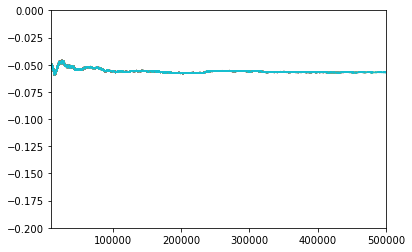

last_avg_reward -0.05709400000000016


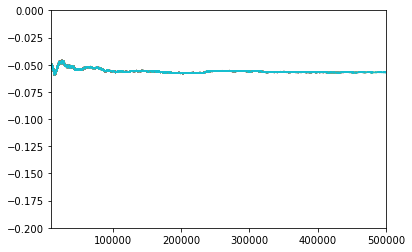

In [22]:
env = gym.make('Blackjack-v0')

import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def test_solution(num_iterations = 100000, plot = False, debug = False):
    avg_rewards = []
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state_full_game(state[0], state[2], state[1])
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = np.argmax(decision_matrix[state_code])
            if debug: print("action", action, decision_matrix[state_code])

            state, reward, done, _ = env.step(action)
            state_code = get_code_by_state_full_game(state[0], state[2], state[1])

            if debug: print("next_state", state, reward, done, some, state_code)

            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards
    
avg_rewards = test_solution(num_iterations = 500000, debug = False, plot = True)